# Twitter Hate Speech Detection

# Business Problem

Human content moderation exploits people by consistently traumatizing and underpaying them. In 2019, an [article](https://www.theverge.com/2019/6/19/18681845/facebook-moderator-interviews-video-trauma-ptsd-cognizant-tampa) on The Verge exposed the extensive list of horrific working conditions that employees faced at Cognizant, Facebook’s former moderation contractor. Unfortunately, every major tech company, including Twitter, uses human moderators to some extent, both domestically and overseas.

Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction. 

Any company with an online forum where users post content could benefit from automating as much as the moderation process as possible. Ultimately, human content moderation is not only detrimental to workers, but also presents a liability to companies that use them.

**Warning:** This notebook contains offensive language from the dataset.

# Data & Methods

The dataset for this capstone project was sourced from a study called *Automated Hate Speech Detection and the Problem of Offensive Language* conducted by Thomas Davidson and a team at Cornell University in 2017. The GitHub repository can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). The dataset is provided as a `.csv` file with 24,802 text posts from Twitter where **6% of the tweets were labeled as hate speech**. 

Since content moderation is so subjective, the labels on this dataset were voted on by crowdsource and determined by majority-rules. The “class” column labels each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. In order to create a different project and adapt the data to my specific business context, I will be treating the data as a binary classification problem. 

Therefore, the final model will be **predicting whether a tweet is hate speech or not.** To prepare the data for this, I will be manually replacing existing 1 and 2 values as 0, and replacing 0 as 1 to indicate hate speech.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import warnings
import string
import re
import os
SEED = 24
warnings.filterwarnings('ignore')
%matplotlib inline
stopwords=set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
from sklearn.svm import LinearSVC

In [2]:
df = pd.read_csv('src/twitter.csv') 
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.describe(include='all')

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783
unique,NaN,NaN,NaN,NaN,NaN,NaN,24783
top,NaN,NaN,NaN,NaN,NaN,NaN,RT @StunningStina: We all know you're fucking ...
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277,NaN
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089,NaN
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000,NaN
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


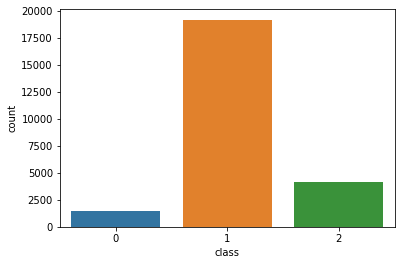

In [5]:
sns.countplot(df['class'])
plt.show()

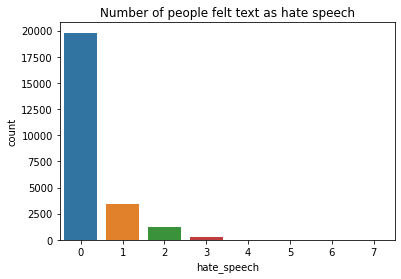

In [6]:
sns.countplot(df['hate_speech'])
plt.title('Number of people felt text as hate speech')
plt.show()

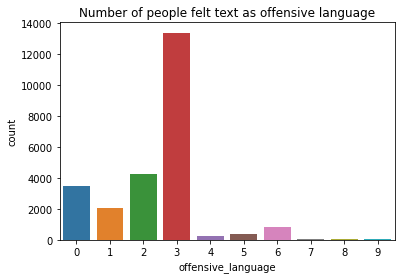

In [7]:
sns.countplot(df['offensive_language'])
plt.title('Number of people felt text as offensive language')
plt.show()

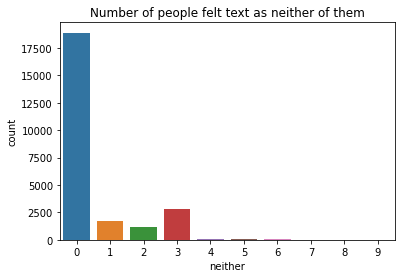

In [8]:
sns.countplot(df['neither'])
plt.title('Number of people felt text as neither of them')
plt.show()

In [9]:
def plot_dist(data):
    
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(data,ax=ax[0])
    sns.boxplot(data,ax=ax[1])
    plt.show()

In [10]:
# number of words
df['Number of words'] = df['tweet'].apply(lambda x: len(x.split(' ')))

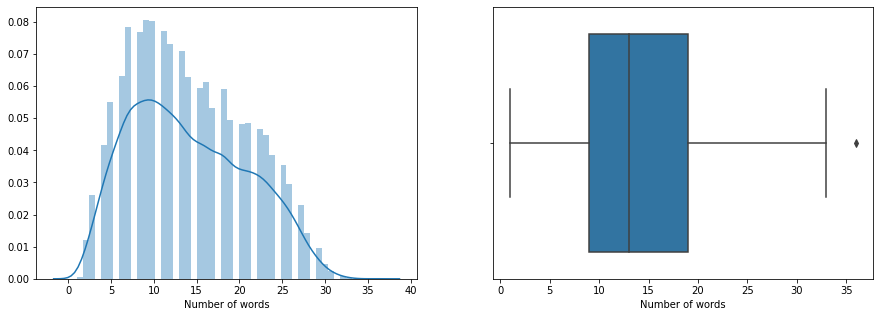

In [11]:
plot_dist(df['Number of words']);

In [12]:
# average word length
df['avg_word_len'] = df['tweet'].apply(lambda x: np.mean([len(c) for c in  x.split(' ')]))

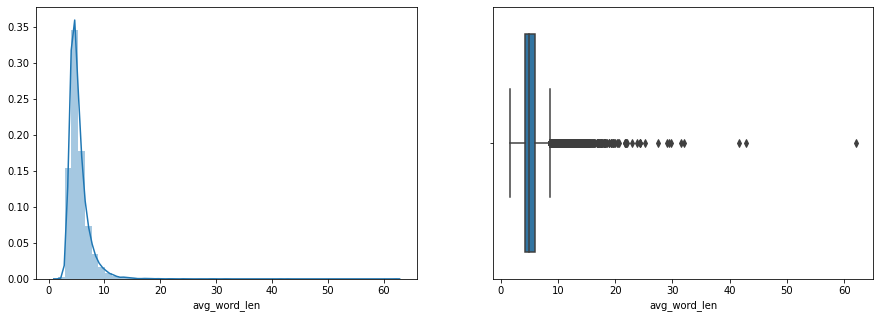

In [13]:
plot_dist(df['avg_word_len']);

In [14]:
# number of stopwords
df['Number of stop words'] = df['tweet'].apply(lambda x: len([c for c in x.split(' ') if c in stopwords]))

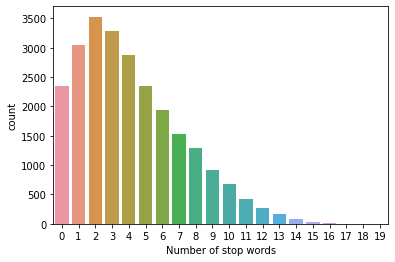

In [15]:
sns.countplot(df['Number of stop words'])
plt.show()

In [16]:
# number of character count
df['Number of char'] = df['tweet'].apply(lambda x: len(x))

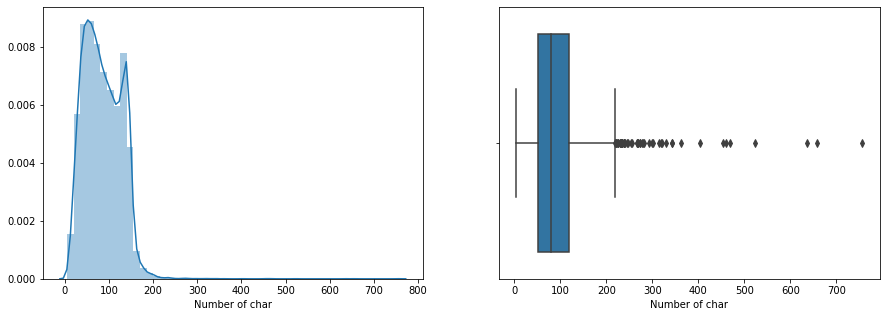

In [17]:
plot_dist(df['Number of char']);

In [18]:
# number of unique
df['Number of unique words'] = df['tweet'].apply(lambda x: len(set(x.split(' '))))

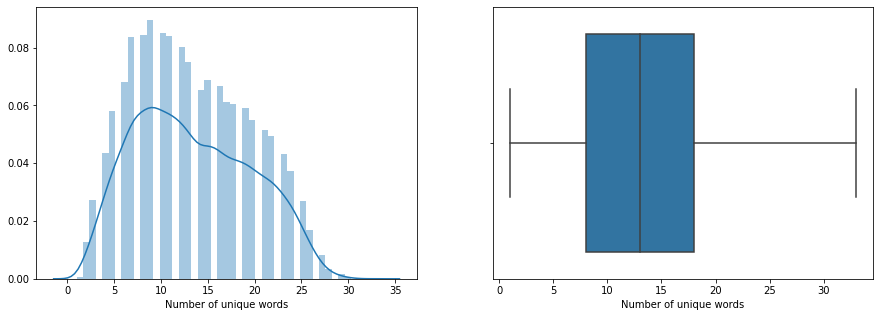

In [19]:
plot_dist(df['Number of unique words']);

In [20]:
# number of urls
df['Number of urls'] = df['tweet'].apply(lambda x: len(re.findall('https?',x)))

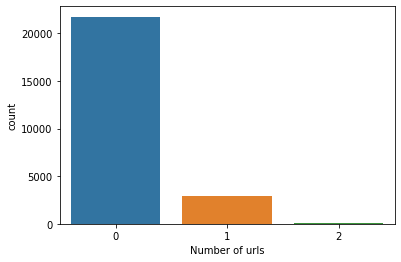

In [21]:
sns.countplot(df['Number of urls'])
plt.show()

In [22]:
# number of emoticons
df['Number of emoticons'] = df['tweet'].apply(lambda x: len(re.findall('&#[0-9]+;',x)))

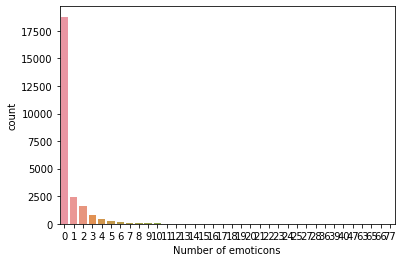

In [23]:
sns.countplot(df['Number of emoticons'])
plt.show()

In [24]:
# number of punctuations
df['Number of punctuations'] = df['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

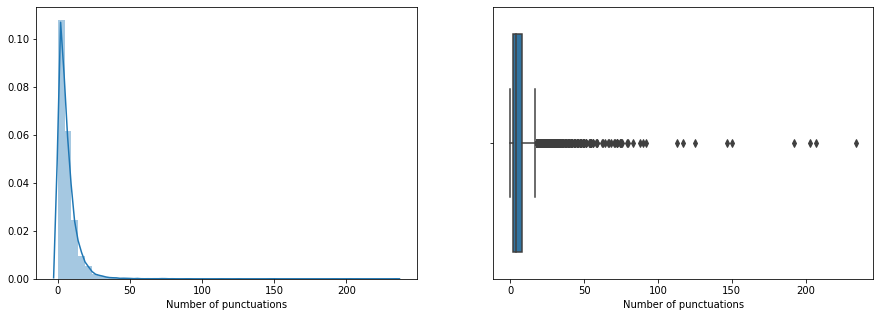

In [25]:
plot_dist(df['Number of punctuations']);

In [26]:
# number of mentions
df['Number of mentions'] = df['tweet'].apply(lambda x: len(re.findall('@',x)))

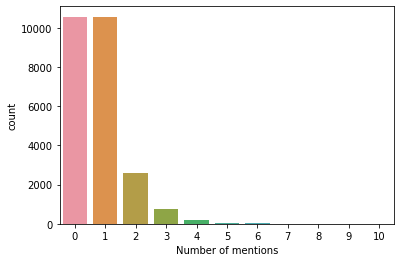

In [27]:
sns.countplot(df['Number of mentions'])
plt.show()

In [28]:
# number of hastags
df['Number of hashtags'] = df['tweet'].apply(lambda x: len(re.findall('#',x)))

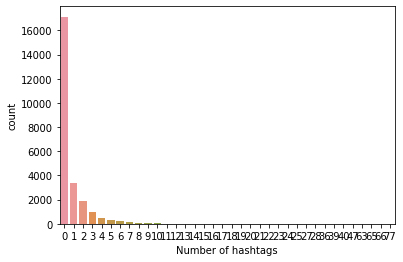

In [29]:
sns.countplot(df['Number of hashtags'])
plt.show()

In [30]:
df["labels"] = df["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"})
print(df.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  Number of words  \
0  !!! RT @mayasolovely: As a woman you shouldn't...               25   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...               16   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...               21   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...                9   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...               26   

   avg_word_len  Number of stop words  Number of char  Number of unique words  \
0      4.640000                    11    

In [31]:
df = df[["tweet", "labels"]]
print(df.head())

                                               tweet                 labels
0  !!! RT @mayasolovely: As a woman you shouldn't...  No Hate and Offensive
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...     Offensive Language
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...     Offensive Language
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...     Offensive Language
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     Offensive Language


In [32]:
def clean(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctuation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)

    return text
df["tweet"] = df["tweet"].apply(clean)

# Decision Tree

In [33]:
x = np.array(df["tweet"])
y = np.array(df["labels"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [34]:
pred = clf.predict(X_test)
print(np.mean(pred == y_test))

0.8708888617190366


In [35]:
# Accuracy score is used to measure the model performance in terms of measuring the ratio of sum of true positive and true negatives out of all the predictions made.
# A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
# A classification report is a performance evaluation metric in machine learning.
print(accuracy_score(y_test , pred))
print(confusion_matrix(y_test , pred))
print(classification_report(y_test , pred))

0.8708888617190366
[[ 137   51  277]
 [  30 1142  207]
 [ 270  221 5844]]
                       precision    recall  f1-score   support

          Hate Speech       0.31      0.29      0.30       465
No Hate and Offensive       0.81      0.83      0.82      1379
   Offensive Language       0.92      0.92      0.92      6335

             accuracy                           0.87      8179
            macro avg       0.68      0.68      0.68      8179
         weighted avg       0.87      0.87      0.87      8179



In [36]:
sample = "Let's unite and kill all the people who are protesting against the government"
data = cv.transform([sample]).toarray()
print(clf.predict(data))

['Hate Speech']


In [37]:
sample = "I love dog"
data = cv.transform([sample]).toarray()
print(clf.predict(data))

['Offensive Language']


In [38]:
sample = "She is a dog"
data = cv.transform([sample]).toarray()
print(clf.predict(data))

['No Hate and Offensive']


In [39]:
print("Training Accuracy :",clf.score(X_train, y_train))
print("Testing Accuracy :", clf.score(X_test, y_test))

Training Accuracy : 0.9980727535533607
Testing Accuracy : 0.8708888617190366


In [40]:
# plt.plot(np.arange(len(pred)) + len(y_train),y_test)
# plt.plot(np.arange(len(pred)) + len(y_train), pred)
# plt.plot(y_train)
# plt.plot(train)

# # you seemed to mess up the labels
# plt.legend(['y_test', 'y_test_pred', 'y_train','y_train_pred'])

<AxesSubplot:>

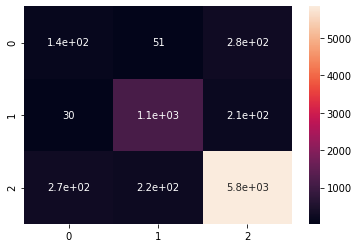

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot = True)

# SVM

In [42]:
from sklearn import svm

In [44]:
x = np.array(df["tweet"])
y = np.array(df["labels"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


from sklearn.svm import SVC
svm = SVC(gamma=2)
svm.fit(X_train,y_train)

SVC(gamma=2)

In [45]:
pred = svm.predict(X_test)
print(np.mean(pred == y_test))

0.776623059053674


In [46]:
sample = "I love dog"
data = cv.transform([sample]).toarray()
print(clf.predict(data))

['Offensive Language']


In [47]:
sample = "She is a dog"
data = cv.transform([sample]).toarray()
print(clf.predict(data))

['No Hate and Offensive']


In [48]:
sample = "Let's unite and kill all the people who are protesting against the government"
data = cv.transform([sample]).toarray()
print(clf.predict(data))

['Hate Speech']


In [49]:
# Accuracy score is used to measure the model performance in terms of measuring the ratio of sum of true positive and true negatives out of all the predictions made.
# A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
# A classification report is a performance evaluation metric in machine learning.
print("Accuracy Score: ", accuracy_score(y_test , pred))
print("Confusion Matrix: ",confusion_matrix(y_test , pred))
print("Classification Report: ",classification_report(y_test , pred))

Accuracy Score:  0.776623059053674
Confusion Matrix:  [[   7    0  458]
 [   2   27 1350]
 [  15    2 6318]]
Classification Report:                         precision    recall  f1-score   support

          Hate Speech       0.29      0.02      0.03       465
No Hate and Offensive       0.93      0.02      0.04      1379
   Offensive Language       0.78      1.00      0.87      6335

             accuracy                           0.78      8179
            macro avg       0.67      0.34      0.31      8179
         weighted avg       0.78      0.78      0.68      8179



# Naive Baye's

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score , classification_report , confusion_matrix

In [ ]:
# X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=100)

In [ ]:
# X_train.shape , X_test.shape , y_train.shape , y_test.shape

In [ ]:
# mnb = MultinomialNB()
# mnb.fit(X_train , y_train)

In [ ]:
# pred = mnb.predict(X_test)
# print(np.mean(pred == y_test))

In [ ]:
# # Accuracy score is used to measure the model performance in terms of measuring the ratio of sum of true positive and true negatives out of all the predictions made.
# # A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
# # A classification report is a performance evaluation metric in machine learning.
# print(accuracy_score(y_test , pred))
# print(confusion_matrix(y_test , pred))
# print(classification_report(y_test , pred))

In [ ]:
# pd.DataFrame(np.c_[y_test , pred] , columns=["Actual" , "Predicted"])